In [1]:
import torch
words = (open('names.txt','r')).read().splitlines()
print(len(words))

32033


In [2]:
words[:6]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte']

In [3]:
X = []
Y = []

def get(s):
    return (ord(s) - ord('a')) + 1

for word in words[:2000]:
    for i in range(len(word)):
        now = [0, 0, 0]
        now1 = 0
        now[1] = get(word[i])
        if(i - 1 >= 0):
            now[0] = get(word[i-1])
        if(i + 1 < len(word)):
            now[2] = get(word[i+1])
        if(i + 2 < len(word)):
            now1 = get(word[i+2])
        X.append(now)
        Y.append(now1)

print(X[:2])
#print(Y)

[[0, 5, 13], [5, 13, 13]]


In [4]:
# uff, we have the dataset, now we make preparations
g = torch.Generator().manual_seed(69*420)
C = torch.randn((27,2),generator=g,requires_grad=True) # this is the lookup table
C.shape

torch.Size([27, 2])

In [5]:
# we need to prepare it for processing by the hidden layer
# so we need to....?
# we need to linearise the data C[X] so that it is easier to play with
# we convert [36,3,2] to [36,6] by just putting all three things linearly
N = C[X].view(len(C[X]),-1)
N.shape

# I guess that's what was needed

torch.Size([3017, 6])

In [6]:
# The hidden layer just does a tanh and sends it forward to the softmax
W1 = torch.randn((6,100),generator=g,requires_grad=True)
B1 = torch.randn(100,generator=g,requires_grad=True)

print(N.shape)
print(W1.shape)
N = torch.tanh(N@W1 + B1)
print(N)

torch.Size([3017, 6])
torch.Size([6, 100])
tensor([[-0.5084,  0.9821,  0.9948,  ...,  0.8410,  0.9050, -0.9690],
        [ 0.3706, -0.5361,  0.9033,  ...,  0.3452,  0.9829, -0.9952],
        [-0.6352, -0.2983,  0.3272,  ...,  0.9990, -0.8990, -0.2820],
        ...,
        [ 0.7919,  0.9998, -0.9997,  ...,  0.6875, -0.8194, -0.9993],
        [-0.9921,  0.8948, -0.2762,  ...,  0.6957,  0.7031, -0.8741],
        [ 0.3998,  0.9955,  0.6289,  ...,  0.9963, -0.5235, -0.9529]],
       grad_fn=<TanhBackward0>)


In [7]:
N.shape

torch.Size([3017, 100])

In [8]:
# softmax layer, we get [36,100] from last layer
# we must return a single layer of size 26 with the probabilities of all chars
W2 = torch.randn((100,27),generator=g,requires_grad=True)
B2 = torch.randn(27,generator=g,requires_grad=True)

logits = N@W2 + B2
counts = logits.exp() # remove the negative logits
probs = counts / counts.sum(1,keepdims=True)

probs

tensor([[3.4689e-10, 1.2802e-04, 2.3130e-05,  ..., 4.5349e-01, 3.2673e-04,
         5.0097e-07],
        [7.6284e-10, 1.0355e-02, 2.0179e-02,  ..., 6.5103e-01, 2.4623e-04,
         2.7340e-08],
        [4.6093e-05, 3.9172e-06, 9.9161e-01,  ..., 1.0914e-10, 3.8243e-05,
         3.6075e-08],
        ...,
        [2.1274e-09, 8.4176e-07, 5.1541e-08,  ..., 9.9940e-01, 2.3539e-10,
         2.1230e-14],
        [3.4769e-07, 2.5967e-04, 5.9365e-01,  ..., 2.7104e-05, 4.8097e-05,
         7.3303e-09],
        [5.1236e-04, 5.3623e-03, 3.5265e-01,  ..., 2.2722e-04, 1.0003e-02,
         4.2293e-08]], grad_fn=<DivBackward0>)

In [9]:
# now we have the final probabilities for each input?, oh wait, its all random right now, we need to train it
# but how do
# the idea is: with a neural network, we are just processing the probabilities, we get what we put in
# its totally random right now, but I need to train it
# but how do I get the output of the things I put in ?
# we have already put in the things that we need to find the probablities of
# how th find em ?
# the things is, we need to find the log likelihood of the expected ouputs with a given input
# and we just have to optimize for that
# okayyy

Streaming output truncated to the last 5000 lines.
0.7986536622047424
0.7986452579498291
0.7986351847648621
0.7986290454864502
0.7986183762550354
0.7986104488372803
0.7986013293266296
0.798592209815979
0.7985837459564209
0.7985754609107971
0.7985669374465942
0.7985583543777466
0.7985498309135437
0.7985411882400513
0.798533022403717
0.7985224723815918
0.7985163927078247
0.7985062003135681
0.7984989881515503
0.7984893321990967
0.7984818816184998
0.7984724640846252
0.7984650135040283
0.798457682132721
0.7984490990638733
0.7984396815299988
0.7984322309494019
0.798421323299408
0.7984158992767334
0.798407256603241
0.798399806022644
0.7983907461166382
0.7983835339546204
0.7983746528625488
0.7983672618865967
0.7983587980270386
0.7983518242835999
0.7983420491218567
0.7983342409133911
0.7983254194259644
0.7983192205429077
0.7983096837997437
0.7983021140098572
0.798293948173523
0.7982863783836365
0.7982785105705261
0.7982705235481262
0.7982620000839233
0.7982543706893921
0.7982454299926758
0.7982

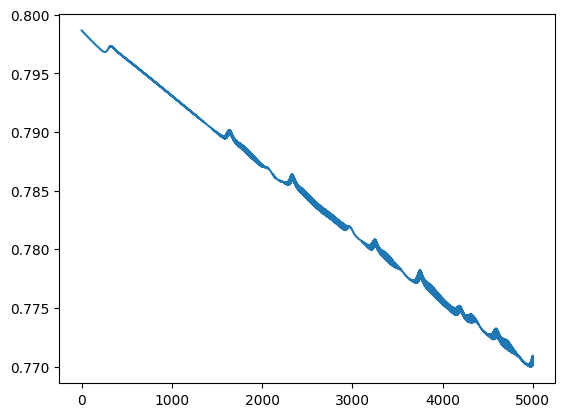

In [36]:
iterations = []
losses = []
import matplotlib.pyplot as plt

def get_loss(probs):
    likelihood = 0
    for i in range(len(X)):
        pro = probs[i, Y[i]]
        likelihood += torch.log(pro)
    likelihood /= len(X)
    loss = -likelihood
    return loss


def reset_grads():
    if W1.grad is not None:
        W1.grad.zero_()
    if W2.grad is not None:
        W2.grad.zero_()
    if B1.grad is not None:
        B1.grad.zero_()
    if B2.grad is not None:
        B2.grad.zero_()
    if C.grad is not None:
        C.grad.zero_()

def gradient_descent():
    learning_rate = 0.250
    W1.data -= learning_rate * W1.grad
    W2.data -= learning_rate * W2.grad
    B1.data -= learning_rate * B1.grad
    B2.data -= learning_rate * B2.grad
    C.data -= learning_rate * C.grad

def update_probs():
    N = C[X].view(len(C[X]), -1)
    N = torch.tanh(N @ W1 + B1)
    logits = N @ W2 + B2
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    return probs

# Initialize `probs` before the loop
probs = update_probs()

# Print initial loss
print(get_loss(probs))


# Training loop
for descent in range(5000):
    # Compute loss
    loss = get_loss(probs)

    # Reset gradients
    reset_grads()

    # Backward pass
    loss.backward()

    # Gradient descent step
    gradient_descent()

    # Recalculate everything with the updated parameters
    probs = update_probs()

    iterations.append(descent)
    losses.append(loss.item())
    # Print the loss
    print(loss.item())
    #print(descent)


plt.plot(iterations,losses)
print(loss.item())

In [1]:
# train using loss decay, one shot shit